# Curve API

In [16]:
import pandas
import requests
import numpy
import matplotlib.pyplot as plt

In [17]:
endpoint = "https://api.curve.fi/api/getWeeklyFees"
data = requests.get(endpoint).json()['data']
weekly_fees = pandas.DataFrame.from_dict(data['weeklyFeesTable'])[::-1]
total_fees = data['totalFees']['fees']

In [18]:
TOL = .001
check_tol = lambda x, y: numpy.abs(x-y) < TOL
assert check_tol(weekly_fees.rawFees.sum(), total_fees), f"hmm... {weekly_fees.rawFees.sum()} != {total_fees}"

In [19]:
endpoint = "https://api.curve.fi/api/getFactoryPools"
data = requests.get(endpoint).json()['data']
pool_data = pandas.DataFrame.from_dict(data['poolData'])
pool_balance_totals = data['totals']

# token_addresses = [pool_data['token'][i]['address'] for i in range(pool_data.shape[0])]
pool_data['tokenSymbol'] = [pool_data['token'][i]['symbol'] for i in range(pool_data.shape[0])]
pool_data['tokenBalance'] = [pool_data['token'][i]['balance'] for i in range(pool_data.shape[0])]

# lp_token_addresses = [pool_data['lpToken'][i]['address'] for i in range(pool_data.shape[0])]
pool_data['lpTokenSymbol'] = [pool_data['lpToken'][i]['symbol'] for i in range(pool_data.shape[0])]
pool_data['lpTokenBalance'] = [pool_data['lpToken'][i]['balance'] for i in range(pool_data.shape[0])]

numeric_columns = ['balance', 'tokenBalance', 'lpTokenBalance']
for c in numeric_columns:
  pool_data[c] = pool_data[c].astype('float')

pool_data = pool_data.sort_values(by='balance')[::-1]

In [20]:
pool_data.drop(columns=['address', 'token', 'lpToken', 'tokenSymbol', 'lpTokenSymbol', 'type']).describe()

,balance,tokenBalance,lpTokenBalance
count,1.070000e+02,1.070000e+02,1.070000e+02
mean,4.621779e+07,2.757246e+07,1.864534e+07
std,3.167317e+08,1.795520e+08,1.454772e+08
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.271500e+01,2.007000e+01,1.044500e+01
50%,1.568600e+02,6.501000e+01,7.031000e+01
75%,1.377130e+03,6.509300e+02,3.177800e+02
max,3.054580e+09,1.564286e+09,1.490294e+09


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  import sys


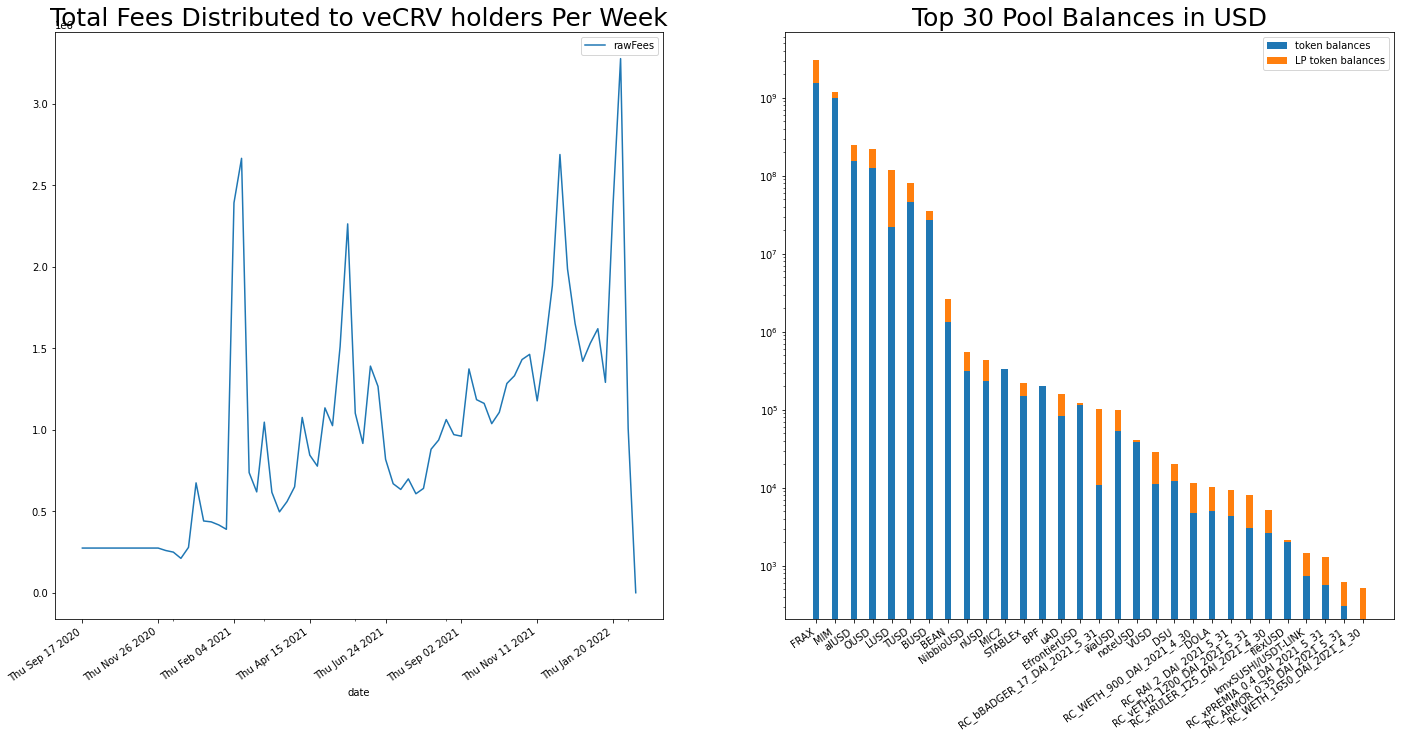

In [21]:
fig, ax = plt.subplots(1,2,figsize=(24,12)) 

N_TICKS = 6
weekly_fees.plot(x='date', y='rawFees', ax=ax[0])
idxs = list(numpy.arange(0, len(weekly_fees), len(weekly_fees) // N_TICKS))
labels = list(weekly_fees.date.values[idxs])
ax[0].set_xticks(idxs, labels)
ax[0].set_title('Total Fees Distributed to veCRV holders Per Week', fontsize=25)

BAR_WIDTH = .35
N = 30
token_balances = pool_data.tokenBalance.values[:N]
lp_token_balances = pool_data.lpTokenBalance.values[:N]
labels = pool_data.tokenSymbol.values[:N]
ax[1].bar(labels, token_balances, BAR_WIDTH, label='token balances')
ax[1].bar(labels, lp_token_balances, BAR_WIDTH, bottom=token_balances, label='LP token balances')
ax[1].set_title(f'Top {N} Pool Balances in USD', fontsize=25)
ax[1].set_yscale('log')
ax[1].legend()

fig.autofmt_xdate(rotation=35);

In [ ]:
pool_address = ['']

endpoint = "https://api.curve.fi/api/getFactoryPools"
data = requests.get(endpoint).json()['data']
pool_data = pandas.DataFrame.from_dict(data['poolData'])
pool_balance_totals = data['totals']

# Dynamic Fees 

https://curve.fi/files/crypto-pools-paper.pdf

In [77]:
def balance_measure(x):
  N = len(x)
  ratio = 1 / N; perfect_ratios = [ratio]*N
  ratios = x / numpy.sum(x)
  max_distance = numpy.max(numpy.abs(perfect_ratios - ratios))
  return 1 - numpy.minimum(max_distance / ratio, 1)

def g(gamma, x_i, N):
  return gamma / (gamma + 1 - numpy.prod(x_i) / (numpy.sum(x_i) / N)**N)

def fee(gamma, x_i, N, f_mid, f_out):
  g_res = g(gamma, x_i, N)
  return g_res*f_mid + (1-g_res)*f_out, g_res

In [78]:
balance_measure([1,1]), balance_measure([1,2]), balance_measure([1,10]), balance_measure([1,0])

(1.0, 0.6666666666666666, 0.18181818181818188, 0.0)

In [79]:
balance_measure([1,1,1]), balance_measure([1,2,3]), balance_measure([1,1,10]), balance_measure([1,1,0])

(1.0, 0.4999999999999999, 0.0, 0.0)

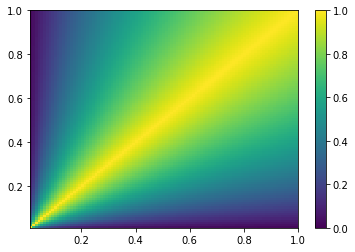

In [80]:
import matplotlib.pyplot as plt
X,Y = numpy.meshgrid(numpy.linspace(0.01,1,100), numpy.linspace(0.01,1,100))
Z = numpy.zeros(X.shape)
for i in range(X.shape[0]):
  for j in range(X.shape[1]):
    a,b = X[i,j], Y[i,j]
    c = balance_measure([a,b])
    if c > 1:
      print(a,b,c)
    Z[i,j] = c

fig = plt.figure()
plt.pcolor(X, Y, Z, vmin=-0, vmax=1)
plt.colorbar()
plt.show()

In [82]:
f_out = 0.008
f_mid = .001
fee_gamma = .01

scenarios = {
    "                 baseline": {'b': numpy.array([1000, 1000]),'p': numpy.array([1, 1])},
    # " uniform balance increase": {'b': numpy.array([2000, 2000]),'p': numpy.array([1, 1])},
    # "different prices balanced": {'b': numpy.array([1000, 500]),'p': numpy.array([1, 2])},
    "           1.5 unbalanced": {'b': numpy.array([1000, 750]),'p': numpy.array([1, 2])},
    "           2.0 unbalanced": {'b': numpy.array([1000, 1000]),'p': numpy.array([1, 2])},  
}

for name, data in scenarios.items(): 
  b, p = data['b'], data['p']
  scaled_balances = b*p
  N = len(b)
  _f, _g = fee(fee_gamma, scaled_balances, N, f_mid, f_out)
  print(f"{name}: f={round(_f, 5)} | balance score: {balance_measure(scaled_balances)}")
  #print(f"{name}: f={round(_f, 5)} | g={round(_g, 5)}")

                 baseline: f=0.001 | balance score: 1.0
           1.5 unbalanced: f=0.0066 | balance score: 0.8
           2.0 unbalanced: f=0.00742 | balance score: 0.6666666666666666


# How does pool balance score relate to fees?

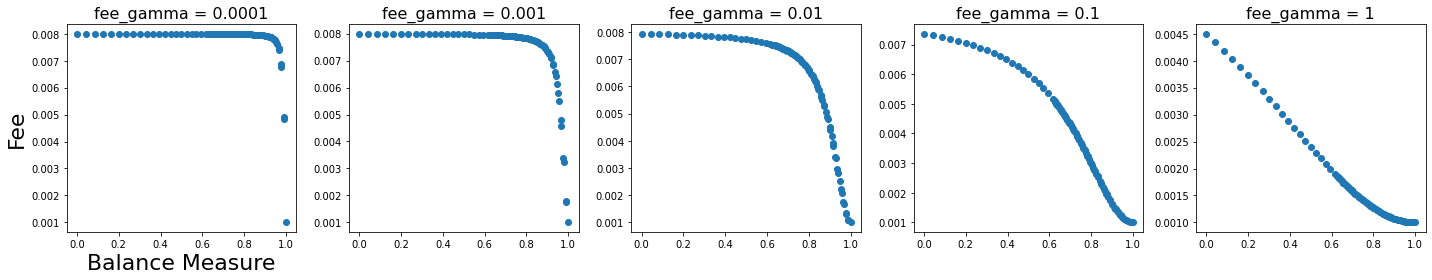

In [109]:
f_out = 0.008
f_mid = .001
fee_gammas = [.0001, .001, .01, .1, 1]
fig, ax = plt.subplots(1, len(fee_gammas), figsize=(4*len(fee_gammas), 4))
for i, fee_gamma in enumerate(fee_gammas):
  fees = []; balances = []
  for b in numpy.linspace(0,1.1,100):
    scaled_balance = [0.5, b]
    _f, _g = fee(fee_gamma, scaled_balance, N, f_mid, f_out)
    fees.append(_f)
    balances.append(balance_measure(scaled_balance))
  ax[i].scatter(balances, fees)
  ax[i].set_title(f"fee_gamma = {fee_gamma}", fontsize=16)
ax[0].set_xlabel("Balance Measure", fontsize=22)
ax[0].set_ylabel("Fee", fontsize=22)
fig.tight_layout();

# TODO: Price as a function of reserves

https://twitter.com/Kurt_M_Barry/status/1404496495492075526

In [27]:
# Reimplemented from:
# https://etherscan.io/address/0x8F68f4810CcE3194B6cB6F3d50fa58c2c9bDD1d5#code
from typing import List

N_COINS = 3  # <- change
A_MULTIPLIER = 10000

MIN_GAMMA = 10**10
MAX_GAMMA = 5 * 10**16

MIN_A = N_COINS**N_COINS * A_MULTIPLIER / 100
MAX_A = N_COINS**N_COINS * A_MULTIPLIER * 1000

def sort(A0: List[int]) -> int:
    """
    Insertion sort from high to low
    """
    A = A0
    N_COINS = len(A0)
    for i in range(1, N_COINS):
        x: int = A[i]
        cur: int = i
        for j in range(N_COINS):
            y: int = A[cur-1]
            if y > x:
                break
            A[cur] = y
            cur -= 1
            if cur == 0:
                break
        A[cur] = x
    return A


def _geometric_mean(unsorted_x: List[int], sort: bool = True) -> int:
    """
    (x[0] * x[1] * ...) ** (1/N)
    """
    N_COINS = len(unsorted_x)
    x: list[int] = unsorted_x
    if sort:
        x = sort(x)
    D: int = x[0]
    diff: int = 0
    for i in range(255):
        D_prev: int = D
        tmp: int = 10**18
        for _x in x:
            tmp = tmp * _x / D
        D = D * ((N_COINS - 1) * 10**18 + tmp) / (N_COINS * 10**18)
        if D > D_prev:
            diff = D - D_prev
        else:
            diff = D_prev - D
        if diff <= 1 or diff * 10**18 < D:
            return D
    raise "Did not converge"


def newton_D(ANN: int, gamma: int, x_unsorted: List[int]) -> int:
    """
    Finding the invariant using Newton method.
    ANN is higher by the factor A_MULTIPLIER
    ANN is already A * N**N
    Currently uses 60k gas
    """

    # Initial value of invariant D is that for constant-product invariant
    N_COINS = len(x_unsorted)
    x = sort(x_unsorted)

    # assert x[0] > 10**9 - 1 and x[0] < 10**15 * 10**18 + 1  # dev: unsafe values x[0]
    # for i in range(1, N_COINS):
    #     frac: int = x[i] * 10**18 / x[0]
    #     assert frac > 10**11-1  # dev: unsafe values x[i]

    D: int = N_COINS * _geometric_mean(x, False)
    S: int = 0
    for x_i in x:
        S += x_i

    for i in range(255):
        D_prev: int = D

        K0: int = 10**18
        for _x in x:
            K0 = K0 * _x * N_COINS / D

        _g1k0: int = gamma + 10**18
        if _g1k0 > K0:
            _g1k0 = _g1k0 - K0 + 1
        else:
            _g1k0 = K0 - _g1k0 + 1

        # D / (A * N**N) * _g1k0**2 / gamma**2
        mul1: int = 10**18 * D / gamma * _g1k0 / gamma * _g1k0 * A_MULTIPLIER / ANN

        # 2*N*K0 / _g1k0
        mul2: int = (2 * 10**18) * N_COINS * K0 / _g1k0

        neg_fprime: int = (S + S * mul2 / 10**18) + mul1 * N_COINS / K0 - mul2 * D / 10**18

        # D -= f / fprime
        D_plus: int = D * (neg_fprime + S) / neg_fprime
        D_minus: int = D*D / neg_fprime
        if 10**18 > K0:
            D_minus += D * (mul1 / neg_fprime) / 10**18 * (10**18 - K0) / K0
        else:
            D_minus -= D * (mul1 / neg_fprime) / 10**18 * (K0 - 10**18) / K0

        if D_plus > D_minus:
            D = D_plus - D_minus
        else:
            D = (D_minus - D_plus) / 2

        diff: int = 0
        if D > D_prev:
            diff = D - D_prev
        else:
            diff = D_prev - D
        if diff * 10**14 < max(10**16, D):  # Could reduce precision for gas efficiency here
            # Test that we are safe with the next newton_y
            for _x in x:
                frac: int = _x * 10**18 / D
                assert (frac > 10**16 - 1) and (frac < 10**20 + 1)  # dev: unsafe values x[i]
            return D

    raise "Did not converge"

In [29]:
def k_0(N, x, D):
  return N**N * numpy.prod(x) / D**N

def k_stable_swap(A, N, x, D):
  return A * k_0(N, x, D)

def k_curve_swap(A, N, x, D, gamma):
  return k_stable_swap(A, N, x, D) * gamma**2 / (gamma + 1 - k_0(N, x, D))**2

# def F(x, D):
  
#   N = x.shape[0]


# def constant_product(): 


# toy example
balances = numpy.array([1000, 500])
prices = numpy.array([1, 2])
scaled_balances = balances*prices

# invariant parameters
A = 3645
N = len(balances)
gamma = 0.00007

token_reserves = numpy.linspace(900, 1100, 1)
new_prices = None

In [30]:
newton_D(ANN = A*N**N, gamma = gamma, x_unsorted = scaled_balances)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: RuntimeWarning: overflow encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:124: RuntimeWarning: overflow encountered in long_scalars


124.51216839625637

# Curve API for pulling APYs visible on curve.fi/pools


In [ ]:
v2_pool_names = ['tricrypto2', 'tricrypto','eurtusd','eursusd','crveth','cvxeth','xautusd','spelleth','teth']
endpoint = "https://api.curve.fi/api/getApys"
all_APYs = requests.get(endpoint).json()['data']
df_data = {'Pool name': [], 'baseAPY': []}
for name in v2_pool_names:
  d = all_APYs[name]
  df_data['Pool name'].append(name)
  df_data['baseAPY'].append(d['baseApy'])
apy_df = pandas.DataFrame(df_data)
apy_df.T

,0,1,2,3,4,5,6,7,8
Pool name,tricrypto2,tricrypto,eurtusd,eursusd,crveth,cvxeth,xautusd,spelleth,teth
baseAPY,0.93,0.51,-0.98,0.23,0.86,1.71,0.35,7.41,-0.13
